# Preparation

This project aims on using Deep Learning with Kullback-Leibler Divergence. Some basic packages are required for this project. The aim of the following chunk is to install required packages such as `lifelines`, `sklearn-pandas` and `torchtuples`. Note that `pycox` is built based on `torchtuples`.



In [ ]:
!pwd
!pip install lifelines
! pip install sklearn-pandas
! pip install torchtuples
! pip install optunity
# ! pip install statsmodels
! pip install statsmodels --upgrade
! pip install pycox

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We have used the API called `google.colab.drive` to get the software. Currently it is a series of python codes that wrapping necessary components for the experiments.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

%cd "/content/drive/MyDrive/Kevin He"
# %pwd
# from pycox.models import LogisticHazard

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Kevin He


`data_simulation` is the simulation codes that used for simulating data for our experiments, `read_data` is a class that can be used to generate different datasets, `KLDL` wraps necessary components.

In [ ]:
import os
import sys
import time

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch # For building the networks 
import torch.nn as nn
import torch.nn.functional as F
import torchtuples as tt

# For preprocessing
from random import sample
# from pycox.models import PMF
# from pycox.models import DeepHitSingle

import KLDL
from KLDL import NewlyDefinedLoss
from KLDL import NewlyDefinedLoss2
import data_simulation
import read_data
import Structure

# MNIST is part of torchvision
from torchvision import datasets, transforms

In [ ]:
np.random.seed(1234)
_ = torch.manual_seed(1234)

If you have mounted the data rightly, you should print out the list for files in given folder. For example, this will print out all files in `/content/drive/My Drive/Kevin He`

In [ ]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022WI folder and put all the files under A4 folder, then "2022WI/A4"
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Kevin He"
GOOGLE_DRIVE_PATH = os.path.join("/content/drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['local_data.csv', 'prior_data.csv', 'local_data_2.csv', 'local_data_3.csv', 'prior_data_subset.csv', 'prior_data_subset_2.csv', 'prior_data_subset_3.csv', 'R-code.ipynb', 'local_data_together.csv', 'Untitled', 'Deep Learning with KL Divergence Simulation Image Data.ipynb', 'Deep Learning with KL Divergence Real Data.ipynb', 'prior_data_subset_4.csv', 'Deep Learning with KL Divergence Simulation Non-linear-prop.ipynb', 'prior_data_subset_5.csv', 'Deep Learning with KL Divergence Simulation 3: Tutorial.ipynb', 'Tutorial 1: Using Our Model with Deep Learning as Prior.ipynb', 'Deep Learning with KL Divergence Simulation 2-2: Tutorial.ipynb', 'Deep Learning with KL-divergence Real Data: Tutorial.ipynb', 'Deep Learning with KL Divergence Simulation 1: Tutorial', 'Deep Learning with KL Divergence Non-linear Visualization.ipynb', '.ipynb_checkpoints', 'Deep Learning with KL Divergence Simulation 2-1: Tutorial.ipynb', '__pycache__', 'data_simulation.py', 'read_data.py', 'Deep Learning with KL 

# Data Preprocessing

You will expect to see:

1. The introduction of the datasets.

2. How to read different kinds of data with `read_data`.

3. How to change the version of the time points when your time is continuous.

## Introduction

Survival Data has its own special data structure that requires special models to analyze. Usually, for one patient (one data point/individual in the dataset), we can define the information as $\{\mathbf Z_i, t_i, \delta_i\}_{i = 1}^n$, with $\mathbf Z_i$ the derived features (the combinations of all raw/baseline features, for example, the second-order term/interaction term of baseline features), $t_i$ is the observed time, and $\delta_i = 1$ means the individual has event time, which is $t_i$. $\delta_i = 0$ means the individual is censored, then $t_i$ is the censored time. 

Due to the existing of time and censoring, we usually focus on modeling the time-related features, such as survival probability or hazard values. We can also provide with a probability of one patient dying in a given period (such as 1-year survival score and so on), and this case is really suitable for discrete-time model in reality.

In this part we have defined several datasets that used in our experiments. 

**Simulation Data**: We have designed a series of simulation data, all three of them have the same features $[x_1, x_2, x_3]$ and the model can be defined as
$$
\lambda(t |x) = \lambda_0(t) \exp(g(x, t))
$$
 but with different model assumptions about $g(x, t)$, and there are three sets of data:
- Model consists of only linear term with no time effect (Simulation Data 1): 
$$g(x, t) = 0.22 x_1 + 0.44 x_2 + 0.88 x_3$$
- Model consists of only linear and non-linear term with no time effect (Simulation Data 2): 
$$
g(x, t) = 0.22 x_1 + 0.44 x_2 + 0.88 x_3 + \frac 23 (x_0^2 + x_2 ^2 + x_0 x_1 + 2x_1 x_2)
$$
- Model consists of linear, non-linear and time effect (Simulation Data 3): 
$$g(x, t) = 0.22 x_1 + 0.44 x_2 + 0.88 x_3 + \frac 23 (x_0^2 + x_2 ^2 + x_0 x_1 + 2x_1 x_2) + |0.2(x_0 + x_1) + 0.5 x_0 x_1|t
$$

Note that we also use simulation data 3 (with sample size $500, 5000, 30000$ for an experiment of hyperparameter tuning (to provide a suitable range of suggestions of tuning parameters), since this case is mostly close to the real case.

*Remark: The time for this data is generated with continuous time points, so you should transform it to discrete version for modeling, see 'Continuous to Discrete' for more details.*


**SUPPORT** [[data link]](https://hbiostat.org/data/repo/SupportDesc.html): The Study to Understand Prognoses Preferences Out
comes and Risks of Treatment (SUPPORT) is a larger
study that researches the survival time of seriously ill
hospitalized adults. The support dataset is a random sample of 1000 patients from Phases I & II of SUPPORT (Study to Understand Prognoses Preferences Outcomes and Risks of Treatment). This dataset is very good for learning how to fit highly nonlinear predictor effects, imputing missing data, and for modeling 4 types of response variables:

- Binary (hospital death)

- Ordinal (severe functional disability)

- Continuous (total hospital costs or possibly study length of stay)

- Time until event (death) with waning effects of baseline physiologic variables over time. Patients are followed up to 5.56 years?

The dataset consists of 9,105
patients and 14 features for which almost all patients have
observed entries (age, sex, race, number of comorbidi
ties, presence of diabetes, presence of dementia, presence
of cancer, **mean arterial blood pressure**, **heart rate**, **respiration rate**, **temperature**, white blood cell count, **serum’s
sodium**, and **serum’s creatinine**), the bolded covariates are those recovered to have non-linear effects w.r.t. the risk score. 

**METABRIC** [[data link]](https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric?resource=download): Cancers are associated with genetic abnormalities. Gene expression measures the level of gene activity in a tissue and gives information about its complex activities. Comparing the genes expressed in normal and diseased tissue can bring better insights into the cancer prognosis and outcomes. Using machine learning techniques on genetic data has the potentials of giving the correct estimation of survival time and can prevent unnecessary surgical and treatment procedures. 

The METABRIC dataset consists of gene expression
data and clinical features for 1,980 patients, and 57.72
percent have an observed death due to breast cancer
with a median survival time of 116 months [2]. We. 
prepare the dataset in line with the Immunohistochem-
ical 4 plus Clinical (IHC4+C) test, which is a com-
mon prognostic tool for evaluating treatment options for
breast cancer patients [3]. We join the 4 gene indicators
(
MKI67, EGFR, PGR, and ERBB2
) with the a patient’s clin-
ical features (hormone treatment indicator, radiotherapy indicator, chemotherapy indicator, ER-positive indicator,
age at diagnosis)

For this dataset, we only follow the version from Deepsurv [4]



**User can also provide with his own dataset for run the model.** But make sure that you have the data structures like below (row: index number, column: column names, including the names of covariates, status and time):


```
  x1  x2  x3  ...  xp  durations  event
1 
2
3
...
```

which means you have to provide the following columns to use our package:

1. covariates for one individual (`x1  x2  x3  ...  xp`): This can be the baseline features and raw features, this can also be the time-dependent features but need careful modifications. More specifically, **you need to ensure that all covariates will not change in the follow-up time period**, otherwise it will be theoretical invalid for our proposed model to be used. 

2. censored status (`event`): Whether this individual is censored or not. If the value is 1, then this individual is not censored and vice versa.

3. observed time (`durations`): When the event time is observed, it means the event time. Otherwise it is the censored time.


## Read Data

`read_data` is the package that used for generating different kinds of data. It consists of simulation data and real data.

Usage: `read_data.simulation_data(option, n, grouping_number)`

`option`: whether the data is linear or non-linear, proportional or non-proportional. There are 3 options: `non linear non ph`, `non linear ph`, `linear ph`.

`n`: The number of data points.

`grouping_number`: The number of groups, with each group the same number of data points. If `grouping_number == 0`, then only one dataset will be generated, otherwise, it will generate a list of datasets. *Required: `n mod grouping_number == 0 if grouping_number > 0`*.

In [ ]:
data_1 = read_data.simulation_data(option = "non linear non ph", n = 30000, grouping_number = 100)
# data_1

In [ ]:
data_1[50][1]

,x1,x2,x3,duration,event,temp
15000,-0.587828,0.798861,0.334242,5.022389,1,50
15001,-0.704029,0.565159,0.718257,1.860517,1,50
15002,-0.391265,-0.816136,-0.349752,20.338627,1,50
15003,-0.027009,0.389027,-0.283012,15.858289,0,50
15004,0.798371,-0.728038,0.828017,8.421642,1,50
...,...,...,...,...,...,...
15295,0.986675,0.563524,0.381906,0.996287,1,50
15296,0.647237,0.212581,0.775605,5.628805,1,50
15297,-0.186607,0.342446,-0.464537,30.000000,0,50
15298,0.765386,-0.855794,0.229596,10.114974,1,50


Usage: `read_data.support_data()`, this will generate the processed SUPPORT data, more information will be described in the paper and added here.

---

Usage: `read_data.metabric_data()`, this will generate the processed METABRIC data, it follows Deepsurv.

In [ ]:
support = read_data.support_data()
support

In [ ]:
metabric = read_data.metabric_data()
metabric

In [ ]:
metabric.groupby("duration").count().iloc[843,]

For the further experiments, we design two schemes of prior data and local data to show the usage of our package. In general, prior data will have sufficient number of data points, but the model assumption/the number of features will be weaker, so here we generate prior data with only linear terms and proportional hazard assumption, but with 10000 data points. For local data, we generate 300 non linear and non proportional hazard data points, and we assume that this is the true model.

In [ ]:
# Default grouping number is 0

data_local = read_data.simulation_data(option = "non linear non ph", n = 300)

prior_data = read_data.simulation_data(option = "linear ph", n = 10000)

## Continuous to Discrete

Most experimental clinical data has continuous event time, which is not suitable for this project. Thus we apply the ways of discretization. More specifically, equi-distance or quantile-based.

Usage: `KLDL.cont_to_disc(data, labtrans = None, scheme = 'quantiles', time_intervals = 20)`

`data`: the dataframe, it should contain `duration` and `event` columns, which is the event time and the event status (censored or not).

`labtrans`: The transforming scheme, a class defined in PyCox. If you would like to pass in a `labtrans` object, the method understand it as you would like to pass a **fitted** scheme, in this case, the scheme will not be fitted by the data, but just do transformation on the data based on the fitted scheme. Otherwise, it will fit a new scheme and return this scheme back for further transformation.

`scheme`: `quantiles` or not.

`time_intervals`: The number of time intervals that you would like to have for the model. Note that the time point will start from $0$. 

In [ ]:
time_intervals = 20

labtrans, prior_data = KLDL.cont_to_disc(prior_data, time_intervals = time_intervals)
data_local = KLDL.cont_to_disc(data_local, labtrans = labtrans, time_intervals = time_intervals)

In [ ]:
prior_data

,x1,x2,x3,duration,event
0,-0.686096,0.551481,-0.932677,14,0
1,-0.978083,-0.359753,0.053454,10,1
2,0.259453,0.763028,0.282278,7,1
3,-0.954624,0.390381,0.769304,10,1
4,0.502788,-0.473844,0.015149,13,1
...,...,...,...,...,...
9995,-0.804342,-0.374652,-0.291306,19,1
9996,-0.220712,-0.690892,-0.774906,4,1
9997,0.837798,-0.581770,0.629657,4,1
9998,0.633505,-0.266602,-0.436441,2,1


In [ ]:
data_local

,x1,x2,x3,duration,event
0,-0.616961,0.244218,-0.124545,10,0
1,0.570717,0.559952,-0.454815,2,0
2,-0.447071,0.603744,0.916279,4,1
3,0.751865,-0.284365,0.001990,18,0
4,0.366926,0.425404,-0.259498,6,0
...,...,...,...,...,...
295,-0.194381,0.862594,0.346326,4,1
296,-0.161540,0.137333,-0.916579,15,0
297,0.991268,0.238008,0.558932,9,1
298,0.862677,-0.316763,0.622598,14,1


In [ ]:
data_local.groupby("duration").count()

,x1,x2,x3,event
duration,,,,
0,4,4,4,4
1,18,18,18,18
2,20,20,20,20
3,13,13,13,13
4,13,13,13,13
5,10,10,10,10
6,18,18,18,18
7,9,9,9,9
8,26,26,26,26


# Model Training

You will expect to see:

1. How to use/train a prior model.

2. How to use the existing prior model to select a proper $\eta$, which is the hyperparameter used to define the weights of prior and local information (maybe changed in the future).

3. How to train a local model with or without the aid of prior model and the selected $\eta$.

4. How to do hyperparameter tuning and our recommendations.

## Introduction: Methodology

Although the survival data structure is special, the model training procedure is still the same as traditional machine learning (we consider deep learning as one model of machine learning, since it focuses on approximating a function, but the goal of training this "function" is the same, which is trained a probability, a binary model in other words). Which requires

- Training, Validation and Test data. *Reminder: Test Data should be first split out since it is the data used for evaluation and should not be messed up with the training process. Validation data is used for early stopping, which means it will be used during the model training*.
- A loss function.
- The optimization algorithm, such as SGD, Adam, AdamW and RMSProp.
- Other tuning hyperparameters for the model.

Here we provide with a comprehensive introduction of our methodology. However you can skip this part if not interested.

### Loss Function (Single Risk)

The loss function for discrete time model can be defined as 
$$
l = \sum_{i = 1}^n \sum_{k = 1}^K Y_i(k)\left[ \log(1 - \lambda( \tau_k | \mathbf Z_i)) + \delta_i(k)  \log \frac{\lambda (t_i | \mathbf Z_i)}{1 - \lambda (t_i | \mathbf Z_i)}\right]
$$
where $Y_i(k) = I(T_i \ge \tau_k), \delta_i(k) = I(T_i = \tau_k, \delta_i = 1)$. This is derived by knowing that 
$$
 L = \prod_{i = 1}^n L_i = \prod_{i = 1}^n f(t_i| \mathbf Z_i)^{\delta_i }S(t_i| \mathbf Z_i)^{1 - \delta_i}
$$
and $ S(\tau_K|\mathbf Z_i) = \prod_{k = 1}^{K}[1 - \lambda(\tau_k|\mathbf Z_i)]$, $f(\tau_K|\mathbf Z_i) = \lambda(\tau_K|\mathbf Z_i)\prod_{k = 1}^{K - 1}[1 - \lambda(\tau_k|\mathbf Z_i)]$. This is also the loss function used by LogisticHazard (Nnet-Survival), and they choose to model hazard function by a neural network. As a comparison, Deephit models Probability Mass Function (PMF, $f$) instead. 

For our model, we would like to use Kullback-Leibler (KL) Divergence as a way to incorporate model. In general, we can define it as 

$$
D_{KL} (\psi_1, \psi_2) = \int \psi_1 \log \frac{\psi_1(x)}{\psi_2(x)} dx
$$

And it is defined as the information loss when $\psi_2$ is used to approximate $\psi_1$, a natural metric of measuring heterogeneity of two functions. So a lower value of $D_{KL} (\psi_1, \psi_2)$ means that the two functions have compatible information sources. 

For our model, we will consider the two functions $\psi_1, \psi_2$ as two probabilistic distributions. We take hazard values as our interest and we will assume that we have two hazard functions $\boldsymbol \lambda, \tilde \lambda$. To be more clear, given the individual $i$ and the time point $\tau_k$, we can find that 
$$
\lambda(\tau_k | \mathbf Z_i) = P(T_i = \tau_k | T_i \ge \tau_k, \mathbf Z_i)
$$
$$
1 - \lambda(\tau_k | \mathbf Z_i) = P(T_i > \tau_k | T_i \ge \tau_k, \mathbf Z_i)
$$
So conditional on $T_i \ge \tau_k$ and $\mathbf Z_i$, we can understand the hazard function as a binary variable, with probability of patient dying on time $\tau_k$ value $\lambda(\tau_k | \mathbf Z_i)$. The patient not dying on time $\tau_k$ value $1 - \lambda(\tau_k | \mathbf Z_i)$. Based on this observation, we can define our own KL divergence

$$
d_{k}\left( \boldsymbol {\tilde \lambda}, \boldsymbol \lambda ; \mathbf{Z}_{i}\right)=\tilde \lambda\left(\tau_k | \mathbf{Z}_{i}\right) \log \left\{\frac{\tilde \lambda\left(\tau_k | \mathbf{Z}_{i}\right)}{\lambda\left(\tau_k | \mathbf{Z}_{i}\right)}\right\}+\left\{1-\tilde \lambda\left(\tau_k | \mathbf{Z}_{i}\right)\right\} \log \left\{\frac{1-\tilde \lambda\left(\tau_k | \mathbf{Z}_{i}\right)}{1-\lambda\left(\tau_k | \mathbf{Z}_{i}\right)}\right\}
$$

with $\tilde \lambda$ the estimated hazard values from the **external** model (prior information) and $\lambda$ the hazard values from the **internal** model (**and are unknown**). It is time-dependent, which means varying the time point $\tau_k$ will lead to the different values of KL divergence since the hazard function depends on a given time point.

The cumulative hazard function for all dataset can be defined as 
$$
D_{KL}(\boldsymbol {\tilde \lambda}, \boldsymbol \lambda) = \sum_{i = 1}^n \sum_{k = 1}^K Y_i(k) d_k(\boldsymbol {\tilde \lambda}, \boldsymbol \lambda; \mathbf x_i)
$$
and simple calculations lead to the result
$$
D_{K L}\left(\boldsymbol {\tilde \lambda}, \boldsymbol \lambda \right)=-\sum_{i=1}^{n} \sum_{k=1}^{K} Y_{i}\left(k \right)\left[\tilde{\lambda}\left(\tau_k | \mathbf Z_{i}\right) \log \left\{\frac{\lambda(\tau_k | \mathbf Z_i)}{1-\lambda(\tau_k | \mathbf Z_i)}\right\}+\log \left\{1-\lambda(\tau_k | \mathbf Z_i)\right\}\right] + C
$$
where $C$ is the constant, terms that not related to $\lambda(\tau_k|\mathbf Z_i), \forall, i, k$. 

To balance the trade-off between internal and external model, we can use a hyperparameter $\eta \ge 0$ to balance the weights. More specifically, we define a penalized log-likelihood as 
\begin{equation}
    l_{\eta} = \frac{l - \eta D_{KL} (\boldsymbol {\tilde \lambda}, \boldsymbol \lambda)}{1 + \eta}
\end{equation}
And our goal is to maximize it. Obviously, larger $\eta$ means more weights on minimizing the difference between internal and external model, which means model will tend to believe more on prior information and vice versa. 

Note that $l_\eta$ can be rewritten as 
\begin{equation}
    l_\eta =\sum_{i=1}^{n} \sum_{k=1}^{K} Y_{i}\left(k \right)\left[ \frac{\delta_i(k) + \eta \tilde \lambda(\tau_k | \mathbf Z_i)}{1 + \eta} \log \left\{\frac{\lambda(\tau_k | \mathbf Z_i)}{1-\lambda(\tau_k | \mathbf Z_i)}\right\}+\log \left\{1-\lambda(\tau_k | \mathbf Z_i)\right\}\right]
\end{equation}
And our goal is to maximize it.

### Loss Function (Competing Risk)

The way of modeling hazard value and using hazard value to define KL Divergence can also be smoothly transformed into our model. We will introduce only core changes of the loss function and leave more details to the paper as reference.

The contribution of the likelihood for an individual $i$ can be written as 
$$
L_{i} = f_{r_i}(t_i)^{\delta_i} S(t_i)^{1- \delta_i} = \lambda_{r_{i}}\left(t_{i} | \mathbf{Z}_{i}\right)^{\delta_{i}}\left(1-\lambda\left(t_{i} | \mathbf{Z}_{i}\right)\right)^{1-\delta_{i}} \prod_{k=1}^{K-1}\left(1-\lambda\left(\tau_k | \mathbf{Z}_{i}\right)\right)
$$
where $t_i = \tau_K$ and $\lambda_{r_i}(t_i | \mathbf Z_i) = P(T^* = t_i, R = r_i \mid T^* \ge t_i, \mathbf Z_i)$, $\lambda(t_i|\mathbf Z_i) = \sum_{r = 1}^q \lambda_r(t_i|\mathbf Z_i) = P(T^* = t_i \mid T^* \ge t_i, \mathbf Z_i)$. $r_i$ is the index of causes that lead to the event.

The total loss function can be defined as 
$$
l = \sum_{i = 1}^n \sum_{k = 1}^K Y_i(k)\left[ \log(1 - \lambda(\tau_k | \mathbf x_i)) + \sum_{r = 1}^q \delta_{i}^r(k)  \log \frac{\lambda_{r} (t_i | \mathbf x_i)}{1 - \lambda (t_i | \mathbf x_i)}\right]
$$
where we define $\delta_i^r(k) = I(T_i = k, R_i = r, \Delta_i = 1)$. 

Following the same way, but changing the binary distribution to multinomial (a clssification problem with $M + 1$ categories and the first $M$ elements have the probability $P(T = \tau_k, R = r | T \ge \tau_k, \mathbf Z_i), r = 1, 2, \ldots, M$, the last one is $P(T > \tau_k| T \ge \tau_k, \mathbf Z_i)$. We can define 
$$
d_{k}\left( \boldsymbol {\tilde \lambda}, \boldsymbol \lambda ; \mathbf{Z}_{i}\right)= \sum_{r = 1}^M \tilde \lambda_r\left(\tau_k | \mathbf{Z}_{i}\right) \log \left\{\frac{\tilde \lambda_r\left(\tau_k | \mathbf{Z}_{i}\right)}{\lambda_r\left(\tau_k | \mathbf{Z}_{i}\right)}\right\}+\left\{1-\tilde \lambda\left(\tau_k | \mathbf{Z}_{i}\right)\right\} \log \left\{\frac{1-\tilde \lambda\left(\tau_k | \mathbf{Z}_{i}\right)}{1-\lambda\left(\tau_k | \mathbf{Z}_{i}\right)}\right\}
$$

and

$$
D_{KL}(\tilde{\boldsymbol{\lambda}}, \boldsymbol{\lambda}) = -\sum_{i=1}^{n} \sum_{k=1}^{K} Y_{i}(k)\left[\sum_{r = 1}^q \tilde \lambda_r \left(\tau_k \mid \mathbf{Z}_{i}\right) \log \left\{ \frac{\lambda_r(\tau_k | \mathbf Z_i)}{1 - \lambda(\tau_k|\mathbf Z_i)} \right\}+ \log \left\{1-\lambda\left(\tau_k | \mathbf{Z}_{i}\right)\right\} )\right]+C
$$
and 
$$
 l_\eta = \sum_{i = 1}^n \sum_{k = 1}^K Y_i(k)\left[ \log(1 - \lambda(k | \mathbf x_i)) + \sum_{r = 1}^q \frac{\delta_{i}^r(k) + \eta \tilde \lambda_r(k|\mathbf x_i)}{1 + \eta}  \log \frac{\lambda_{r} (t_i | \mathbf x_i)}{1 - \lambda (t_i | \mathbf x_i)}\right]
$$

### Optimizer

The optimizers can be different, but mainly we recommend [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) and [RMSProp](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html). These three optimizers behave really similar in our test and we put all the three optimizers into the hyperparameter tuning. 

### Model Structure

The structure of neural network (The sizes of the parameters and the non-linear activation function in each layer) can be uniquely defined by a series of hyperparameters. We will provide with these options in the "hyperparameter tuning" section.

### Proportional Version: 3 Link Functions

In Survival Analysis, there are 3 link functions that are frequently used for modeling. Although deep learning demonstrates a high flexibility of modeling non-linear, non-proportional data, in many cases where data is shown to have some statistical properties, using deep learning will instead lead to an inferior result. That is the reason we still provide with an option to simulate a function that can be proportional in some cases. 

In general, we can uniformly define the model as 

$$
h[d \Lambda (t, x)] = h[d \Lambda_0 (t)] + Z(t)' \beta
$$

where $h$ is a monotone-increasing and twice-differentiable function mapping $[0, 1]$ into $[-\infty, \infty]$ with $h(0) = - \infty$. Then we have the following 3 options:

1. $h(u) = \log (- \log (1 - u))$ (grouped relative risk model)
2. $h(u) = \log u$ (discrete relative risk model)
3. $h(u) = \log \frac u {1 - u}$ (discrete logistic model)

The code patch is shown below


```
if(option == "log-log"):
  input = input + torch.log(-torch.log(torch.sigmoid(self.a)))
  input = 1 - torch.exp(-torch.exp(input))
  return input
elif(option == "log"):
  input = input + torch.log(torch.sigmoid(self.a))
  input = torch.exp(input)
  return input
elif(option == "logit"):
  return torch.sigmoid(input + self.a)
```



Here is an illustration that shows the details of the last 3 layers
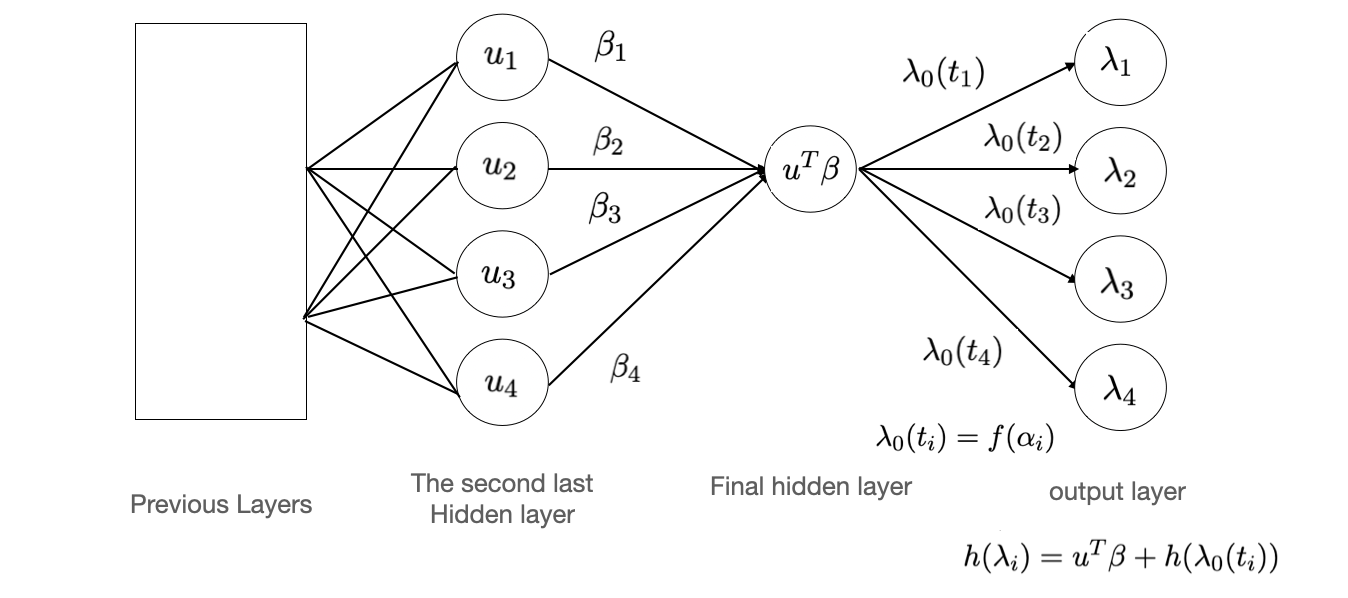

Here we assume that the number of nodes in the second last hidden layer is $4$, with $u_i, i = 1, 2, 3, 4$ the values that gotten by previous layers, $\beta_i$ is the weight connecting final hidden layer and the second last hidden layer, which is parameters that need to be estimated. Then a linear combination $u^T \beta$ is computed as the value of final hidden layer. After that, we define the weights connecting the last two layers as $f(\alpha_i)$, with $\alpha_i$ the parameters that originally initialized in the model, and $f$ be the pre-defined function that need to transform the weight to a baseline hazard value $\lambda_0(t_i)$ and it is determined by the link function we chosen. At last, the operation rules for the last two layers are defined by our own, following the formula. Note that if we assume the covariates for the input layer are time-independent, then since for each time point, the effect of covariates $u^T \beta$ is the same for each time point, we can guarantee that the neural network can simulate a proportional hazard model. However, if the covariates themselves are time-dependent, then no matter which design we use, the model will be non-proportional.

**Non-proportional (Flexible): Why?**

We can also provide with a flexible version (without carefully design of the structure for the last several layers except for a sigmoid function) of model structure

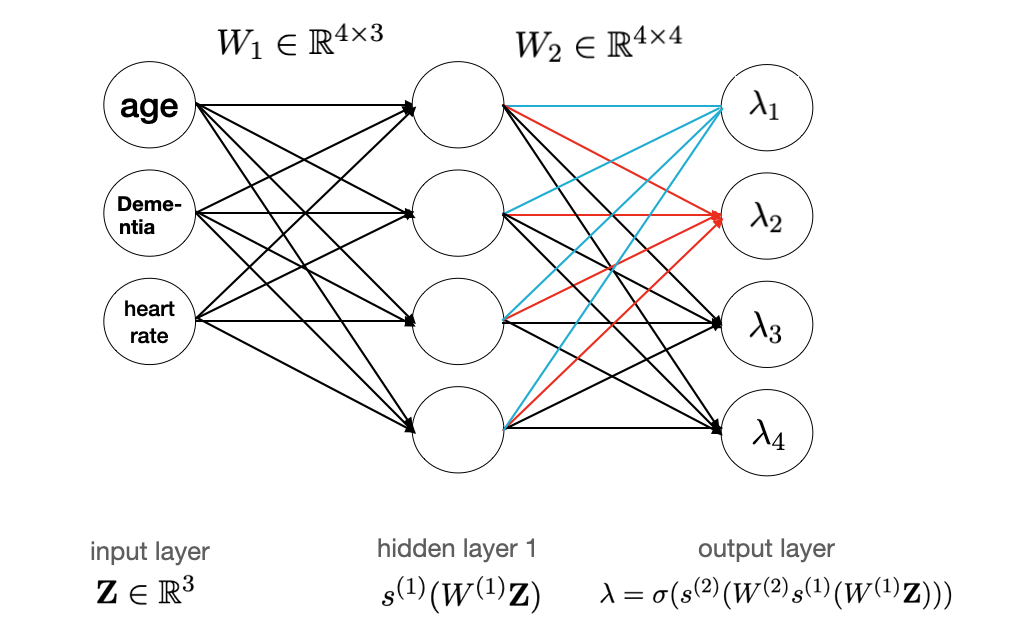

See the red and blue lines for weights connecting to $\lambda_1, \lambda_2$, where $ \lambda_1$ means the hazard value at time point $\tau_1$, $\lambda_2$ means the hazard value at time point $\tau_2$. You can see although the $\lambda_1, \lambda_2$ will be connected with all the nodes in the last layer, the weights are totally different and they vary with time, so we can understand it as a model $y = x^\top \beta(t)$, with $\beta(t)$ different initial values when they are connected with values at different time points.

A result for the comparison

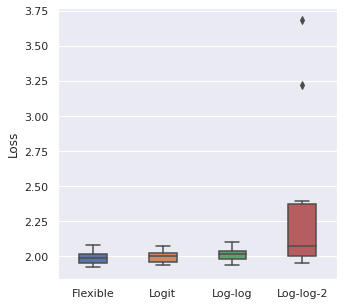

## Prior Model

The core purpose of this project is to let user incorporate prior information by themselves. To incorporate the prior information, one should provide with a prior model with estimated parameters. 

For example, suppose we have local features $[x_1, x_2, \ldots, x_{10}]$ but with prior model a partial model
$$
\hat y = x_1 + 2x_2 + 3x_3 + 2x_4 + 4x_5
$$
Then you should record the estimated parameters in the prior model and define the way for computing the prior information, whether it is an additive model ($x^T \beta$) or multiplictive model (for example, $\prod e^{x_i \beta_i}$). Which means you should store the parameter list as $[1, 2, 3, 2, 4, 0, 0, \ldots, 0]$, with coefficients of covariates not shown in the prior model $0$.

However, if you do not have a prior model, our software can also provide with a model with user-provided data, it can be all deep learning models that this software wraps, such as Deephit and LogisticHazard. We will show how to train a deep learning model in this tutorial, too.

Usage: `KLDL.prior_model_generation(data, parameter_set = None, time_intervals = 20, dropout = 0.1, optimizer = tt.optim.Adam(), epochs = 512, patience = 5, verbose = False)`

`data`: prior_data

`parameter_set`: The hyperparameters dict related to the model structure that can be tuned. It consists of:

* number of hidden_nodes (default 32)
* number of hidden_layers (default 2)
* whether use Batch Normalization or not (default `True`)
* learning rate (default 0.01)
* batch size (default 32)

**For more details, see the introduction of potential hyperparameters in the "Hyperparameter Tuning" section.**

`time_intervals`: time points for the discrete model, should be the same as the number you have assigned if you use `cont_to_disc()` to transform continuous time to discrete version.

`dropout`: dropout rate

`optimizer`: optimizer, wrapped by `torchtuple`

`epochs`: maximum epochs for training

`patience`: The waiting steps used in earlystopping

`verbose`: Whether you want to print out the logs for deep learning model training

In [ ]:
parameter_set = {
    "hidden_nodes": 32,
    "hidden_layers": 2,
    "batch_norm": True,
    "learning_rate": 0.0001,
    "batch_size": 64
}

In [ ]:
model_prior = KLDL.prior_model_generation(prior_data, parameter_set = parameter_set, verbose = True)

0:	[0s / 0s],		train_loss: 7.3568,	val_loss: 7.0698
1:	[0s / 0s],		train_loss: 7.0838,	val_loss: 6.8651
2:	[0s / 0s],		train_loss: 6.8679,	val_loss: 6.6718
3:	[0s / 1s],		train_loss: 6.6699,	val_loss: 6.4206
4:	[0s / 1s],		train_loss: 6.4742,	val_loss: 6.2677
5:	[0s / 1s],		train_loss: 6.2789,	val_loss: 6.0167
6:	[0s / 1s],		train_loss: 6.0712,	val_loss: 5.7752
7:	[0s / 2s],		train_loss: 5.8533,	val_loss: 5.5922
8:	[0s / 2s],		train_loss: 5.6108,	val_loss: 5.3269
9:	[0s / 2s],		train_loss: 5.3443,	val_loss: 5.1118
10:	[0s / 3s],		train_loss: 5.0714,	val_loss: 4.8362
11:	[0s / 3s],		train_loss: 4.7955,	val_loss: 4.5249
12:	[0s / 3s],		train_loss: 4.5107,	val_loss: 4.2332
13:	[0s / 3s],		train_loss: 4.2357,	val_loss: 4.0274
14:	[0s / 4s],		train_loss: 3.9955,	val_loss: 3.7291
15:	[0s / 4s],		train_loss: 3.7467,	val_loss: 3.5545
16:	[0s / 4s],		train_loss: 3.5186,	val_loss: 3.3106
17:	[0s / 4s],		train_loss: 3.3526,	val_loss: 3.1451
18:	[0s / 5s],		train_loss: 3.1951,	val_loss: 3.0169
19:

### Hyperparameter Tuning: A Recommendation

It is recommended that we use hyperparameter tuning for the prior model (and also the local model). The parameters that can be used for tuning are listed below.

* **number of hidden_nodes**: This is the number of hidden nodes for each hidden layer, for saving the time of tuning we assume the hidden nodes for each layer are the same. In general tuning this parameter will have little obvious pattern of improvement given the same computational cost, so we only provide with three options $[32, 64, 128]$, which are also commonly used in other models used in Survival Analysis. 

* **number of hidden_layers**: This is the number of hidden layers. Deeper neural network will have a better representation ability, which means easier to train a better model w.r.t. different metrics. However, it will also make the computational cost much higher. In general, we recommend user to have the number of layers to be chosen from $2$ to $5$, since if the neural network is too deep, it will make the training much more complicated and the gradient vanishing/exploding problem may be accumulating. 

* **whether use Batch Normalization or not**: [BatchNorm](http://proceedings.mlr.press/v37/ioffe15.pdf) is recommended to deal with concept drift problem, it is strongly recommended when the trained network is deep (number of hidden_layers $\ge 2$). 

* **learning rate**: The learning rate for the optimizer, it will vary a lot for different datasets. So our recommended values will also be multiple based on our test for different sizes of the dataset.

* **batch size**: Instead of computing the gradient using the whole dataset ($\frac 1n \sum_{i = 1}^n \nabla_\theta f(\mathbf x_i)$) or using only one data point (SGD, $\nabla_\theta f(\mathbf x_{i_k}))$, we compute the gradient for one batch of dataset ($\frac 1b \sum_{i \in I}\nabla_\theta f(\mathbf x_i), |I| = b$). The value of $b$ is chosen based on the size of data, but in general the maximum value of $b$ should not be over $0.05n$. 


Here are some experiments showing the test results: 


**Batch Size**

From left to right, top to bottom, we have generated 30000, 5000 and 500 data points following Simulation Data 3 and also a real dataset SUPPORT. We have found that about $5\%$ of the size is a maximum boundary for the mini-batch training, for the minimum, it is a little hard to determine, but $0.1 - 1\%$ of the size is a safe range, which means that if you have a data size of 10000, then we recommend tuning the batch size from 10 to 500.

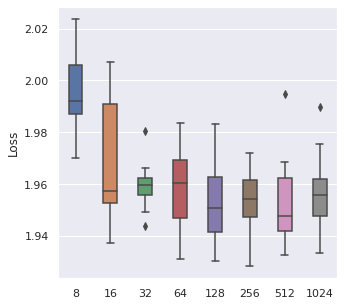
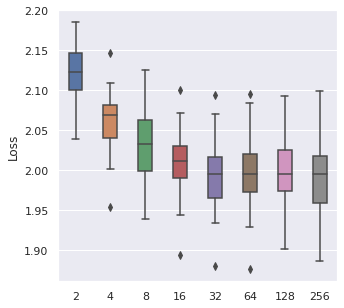
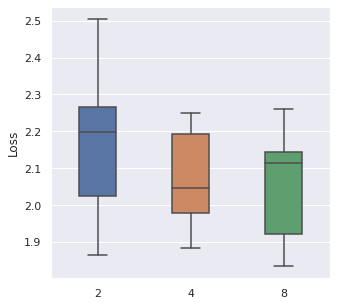
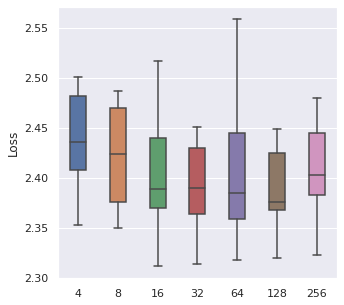

---

The time cost can also be viewed in the same order, too. A take-home message is that: approximately $1\%$ of the data size can be set as the batch size when we also consider the time cost.

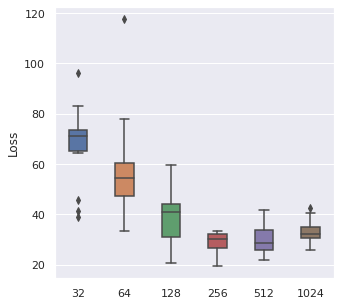
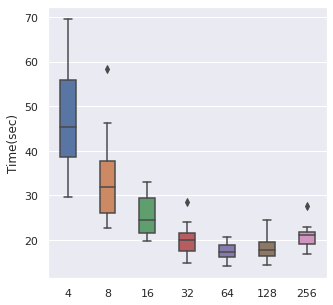
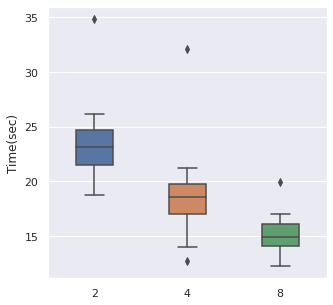
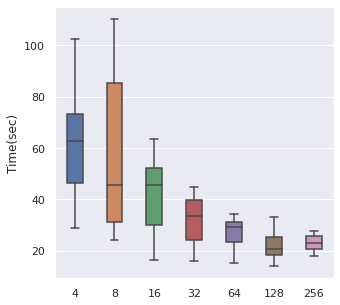

---

**Learning Rate**

We have taken a series of values for potential learning rate, which are $[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]$, we have observed that the values from $0.0001$ to $0.05$ can be a proper range, so this will be our range for tuning.

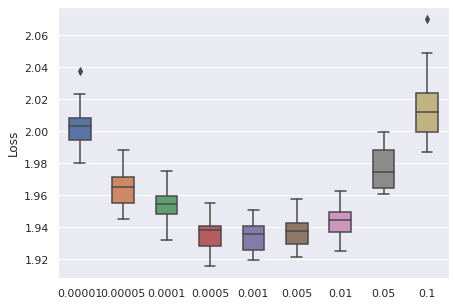
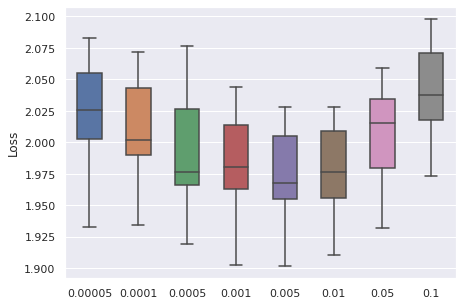
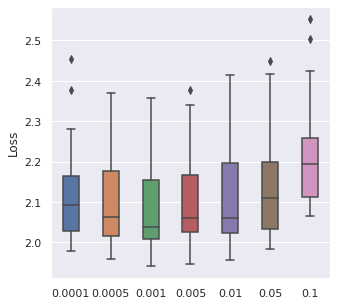
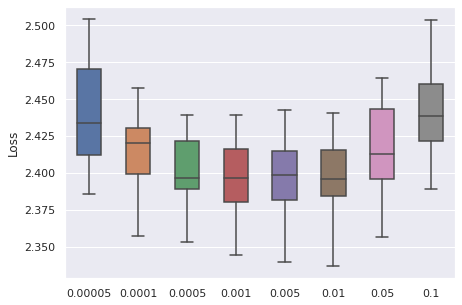

---

The time cost can be viewed with the same order. In general, higher learning rate means faster convergence, so people can tune from the largest to the smallest learning rate for saving time.

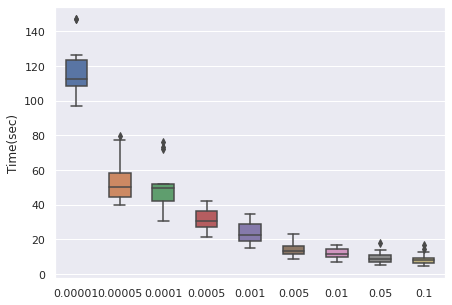
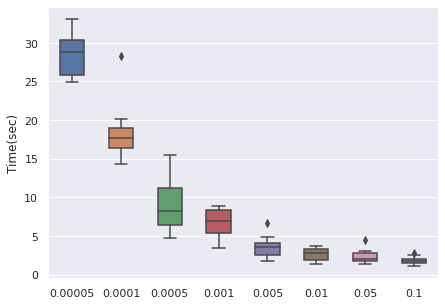
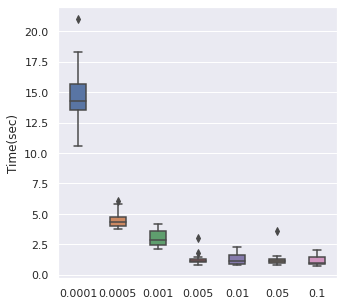
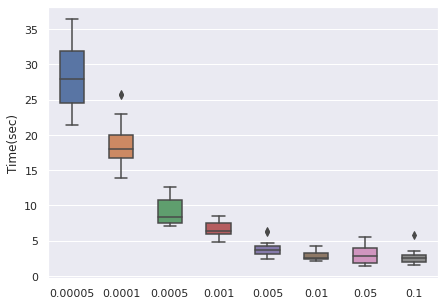

**Optimizer**

We have tried 4 optimizers (SGD, Adam, RMSProp, AdamW) and 3 are comparable, the other one is inferior. So these three optimizers will be used.

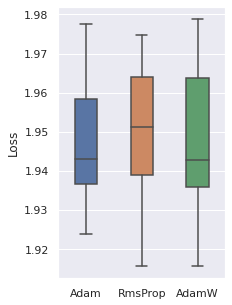
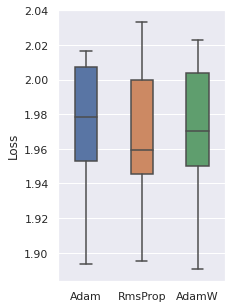
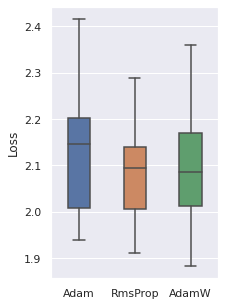
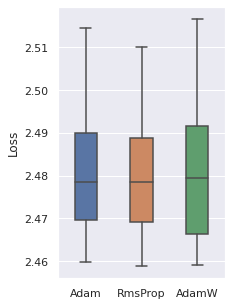

---

The time cost can be viewed with the same order, note that RmsProp is the option with the least time cost.

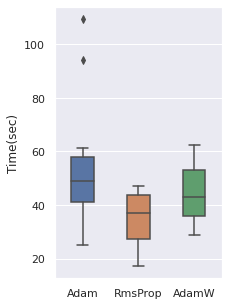
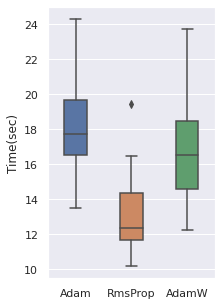
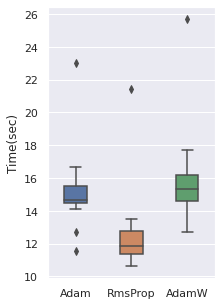
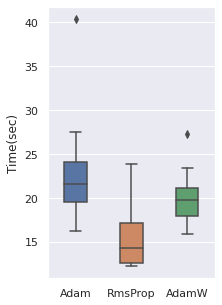

**Dropout Rate**

We take $[0, 0.1, 0.25, 0.5]$ as potential values for tuning and for the first three values, there are no significant difference but they all behave better than the $0.5$ case. This is reason that for default hyperparameter tuning recommendation, we will use $[0, 0.1, 0.25]$ as 3 potential options.

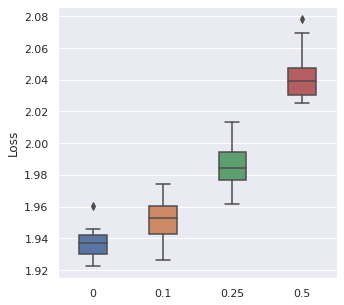
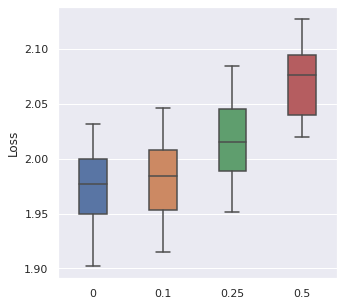
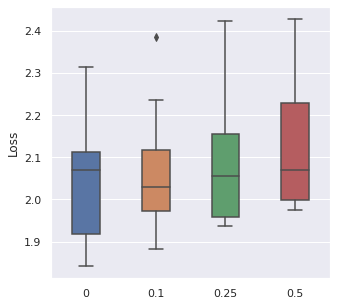
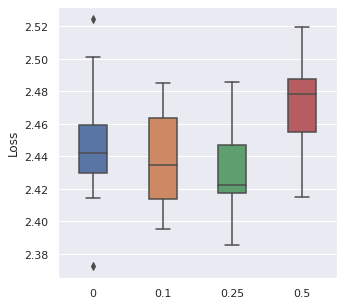
---

The time cost can be viewed with the same order. No clear result is shown.

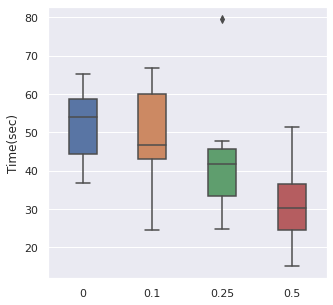
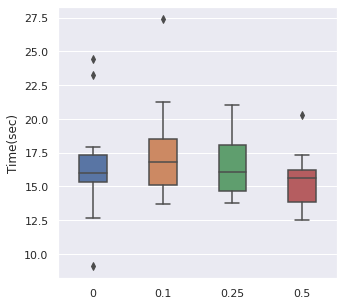
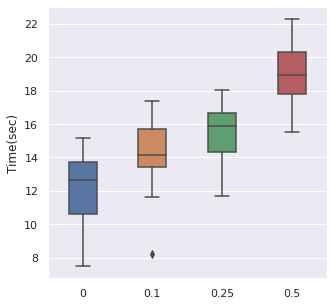
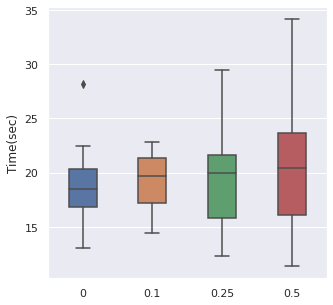

Usage: `KLDL.hyperparameter_set_list(hidden_nodes=[32, 64, 128],
                            hidden_layers=[2, 3, 4],
                            batch_norm=[True, False],
                            learning_rate=[0.0005, 0.001, 0.01, 0.1],
                            batch_size=[32, 64, 128])`

Generate a list of dicts using Grid Search, each one is a hyperparameter set that can be directly passed as `parameter_set` parameter in method `model_generation`. The description 5 options can be seen above (usage of `KLDL.prior_model_generation`). 

*Required: Each parameter in this method must be a list even if only one element is passed*.

In [ ]:
KLDL.hyperparameter_set_list(hidden_nodes=[32, 64], hidden_layers = [2], batch_norm = [True], learning_rate = [0.001, 0.01], batch_size=[32])

[{'batch_norm': True,
  'batch_size': 32,
  'hidden_layers': 2,
  'hidden_nodes': 32,
  'learning_rate': 0.001},
 {'batch_norm': True,
  'batch_size': 32,
  'hidden_layers': 2,
  'hidden_nodes': 32,
  'learning_rate': 0.01},
 {'batch_norm': True,
  'batch_size': 32,
  'hidden_layers': 2,
  'hidden_nodes': 64,
  'learning_rate': 0.001},
 {'batch_norm': True,
  'batch_size': 32,
  'hidden_layers': 2,
  'hidden_nodes': 64,
  'learning_rate': 0.01}]

Below is a sketch of doing hyperparameter tuning. Due to the time limit, we do not test it in this tutorial.

In [ ]:
# DO NOT RUN!!

best_model = None
best_score = 10000

set_list = KLDL.hyperparameter_set_list()
for i in set_list:
  log, model = KLDL.model_generation(data, parameter_set = i)
  score = log.to_pandas().val_loss.min()
  if(score < best_score):
    best_score = score
    best_model = model

## Cross Validation (CV)

After we train a prior model, we need to decide the value of $\eta$ to see how much we can 'trust' the information from the prior model. Mathematically, $l_\eta = \frac{l - \eta l_{KL}}{\eta + 1}$, so we can understand the combined loss as '1 local information and $\eta$ prior information'. For better understanding, if $\eta = 1$, this means the weights for local and prior information are 50-50 ($\frac 1 {1 + 1} = \frac 12 = 50\%$). The CV will be done 5-fold and the metrics will be averaged. Currently C-index is used, measured on a separate dataset in the local data. 

Usage: `KLDL.cross_validation_eta(df_local, eta_list, model_prior, parameter_set=None,
                         time_intervals=20,
                         dropout=0.1,
                         optimizer=tt.optim.Adam(),
                         epochs=512,
                         patience=5,
                         verbose=False)`

`df_local`: (local) data

`eta_list`: The list of $\eta$ that we would like to chosose.

`model_prior`: The trained prior model

For others, see above.

*Remark: Except for the best $\eta$ that this method will return, it will also return `df_train, df_test, x_test`. This is because we want the CV part and the further local model training having the same training and test split (**the test data will be used for evaluation for all models used for comparison**). So we would like to do this splitting in this function and then use the splitted data for further steps.*

In [ ]:
eta_list = [0.1, 1, 5]
eta, df_train, df_test, x_test = KLDL.cross_validation_eta(data_local, eta_list, model_prior)

NameError: ignored

In [ ]:
eta

0.1

## Local Model Training

We will train two versions of model (same model structure, only difference is whether we have prior information). As a reminder, we firstly have the prior model to get the prior information, which is the time-dependent hazard function at each time point for each individual obtained by external model, and then we compute the loss function with the aid of prior information and selected $\eta$.

We will use the selected $\eta$ and the trained prior model to train our local model. Note that we will not use the same splitting as what have shown before (The `df_train` and `df_test` that output from `KLDL.cross_validation_eta`.

Usage: `KLDL.mapper_generation(cols_standardize = None, cols_leave = None)`

`cols_standardize`: The list of features that user would like to choose for standardization. 

`cols_leave`: The list of features that user would like to choose without any operations. 

This function will return a mapper that will be used for transforming dataframe to array matrix in `numpy`. 

*Remark: The features that will be generated into the array matrix will be `cols_standardize + cols_leave`. It is **NOT** a default version that the features not in `cols_standardize` will be in `cols_leave`.*

Usage: `KLDL.model_generation(x_train, x_val, y_train, y_val, with_prior=True, eta=None, model_prior=None,
                     parameter_set=None,
                     time_intervals=20,
                     dropout=0.1,
                     optimizer=tt.optim.Adam(),
                     epochs=512,
                     patience=5,
                     verbose=False)`

`x_train, x_val, y_train, y_val`: x and y data that used for training the model

`with_prior`: whether you want to incorporate prior model. If `False`, `eta` and `model_prior` will not be required

For other parameters, see above.

*Remark: We pass the data in a seemly weird way (`x_train, x_val, y_train, y_val` but not `df_train, df_val`) due to the reason that for model with or without prior information, the data structure used for model training is different.*

In [ ]:
parameter_set = {
    "hidden_nodes": 32,
    "hidden_layers": 2,
    "batch_norm": True,
    "learning_rate": 0.005,
    "batch_size": 8
}

In [ ]:
df_train = data_local.copy()

df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

mapper = KLDL.mapper_generation(cols_standardize = ['x1', 'x2', 'x3'])

x_train = mapper.fit_transform(df_train).astype('float32')
x_val = mapper.transform(df_val).astype('float32')

y_train = (x_train, df_train['duration'].values, df_train['event'].values)
y_val = (x_val, df_val['duration'].values, df_val['event'].values)

model = KLDL.model_generation(x_train, x_val, y_train, y_val, eta = eta, model_prior = model_prior, parameter_set = parameter_set, verbose = True, option = 'logit')

NameError: ignored

We can also train a normal model, which is the model that will not incorporate prior information.

In [ ]:
parameter_set = {
    "hidden_nodes": 32,
    "hidden_layers": 2,
    "batch_norm": True,
    "learning_rate": 0.005,
    "batch_size": 4
}

In [ ]:
# The data structure of y_train and y_val is different

get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))

y_train = get_target(df_train)
y_val = get_target(df_val)

# Flexible v.s. Proportional: Option
model_2 = KLDL.model_generation(x_train, x_val, y_train, y_val, with_prior = False, parameter_set = parameter_set, verbose = True, option = "log-log-2")

0:	[0s / 0s],		train_loss: 7.0819,	val_loss: 3.7052
1:	[0s / 0s],		train_loss: 3.4381,	val_loss: 2.8337
2:	[0s / 0s],		train_loss: 2.6907,	val_loss: 2.6962
3:	[0s / 0s],		train_loss: 2.5385,	val_loss: 2.6212
4:	[0s / 0s],		train_loss: 2.4844,	val_loss: 2.6099
5:	[0s / 0s],		train_loss: 2.4048,	val_loss: 2.6147
6:	[0s / 1s],		train_loss: 2.3695,	val_loss: 2.5602
7:	[0s / 1s],		train_loss: 2.3476,	val_loss: 2.5596
8:	[0s / 1s],		train_loss: 2.3911,	val_loss: 2.5445
9:	[0s / 1s],		train_loss: 2.3603,	val_loss: 2.5231
10:	[0s / 1s],		train_loss: 2.3447,	val_loss: 2.5492
11:	[0s / 1s],		train_loss: 2.3154,	val_loss: 2.4993
12:	[0s / 1s],		train_loss: 2.3382,	val_loss: 2.4723
13:	[0s / 1s],		train_loss: 2.2891,	val_loss: 2.4805
14:	[0s / 2s],		train_loss: 2.3094,	val_loss: 2.4705
15:	[0s / 2s],		train_loss: 2.2250,	val_loss: 2.4442
16:	[0s / 2s],		train_loss: 2.2376,	val_loss: 2.4248
17:	[0s / 2s],		train_loss: 2.2272,	val_loss: 2.4317
18:	[0s / 2s],		train_loss: 2.1960,	val_loss: 2.3874
19:

# Evaluation

## Introduction: Methodology

In Survival Analysis, there are so many possible metrics that can be used for evaluation. We hereby introduce them and same, for readers who are not interested, you can skip this part.

### Harrell's C-index

The core principle for Harrell's C-index is given a set of comparable pairs, the individual with longer event time should have a smaller survival probability. To be more concrete, it is defined as 

$$
C = P(S(t|\mathbf Z_i(\mathbf t)) < S(t|\mathbf Z_j(\mathbf t)) \mid T_i < T_j \land \Delta_i = 1) = \frac{\pi_{conc}}{\pi_{comp}}
$$

where $\pi_{comp} = P(T_i < T_j \land \Delta_i = 1)$ and $\pi_{conc} = P(S(t|\mathbf x_i(\mathbf t)) < S(t|\mathbf x_j(\mathbf t)) \land T_i < T_j \land \Delta_i = 1)$. This comes from the concept of area under curve (AUC).

For computation, we define

$$
\operatorname{comp}_{i j}=I\left\{t_{i}<t_{j} \& d_{i}=1\right\}+I\left\{t_{i}=t_{j} \& d_{i}=1 \& d_{j}=0\right\}
$$
and
$$
\text { conc }_{i j}=I\left\{z\left(\mathbf{x}_{i}\right)>z\left(\mathbf{x}_{j}\right)\right\} \cdot \operatorname{comp}_{i j}
$$
we can have the computation steps
$$
c=\frac{\sum_{i=1}^{n-1} \sum_{j=i+1}^{n}\left(\operatorname{conc}_{i j}+\operatorname{conc}_{j i}\right)}{\sum_{i=1}^{n-1} \sum_{j=i+1}^{n}\left(\operatorname{comp}_{i j}+\operatorname{comp}_{j i}\right)}=\frac{\sum_{i=1}^{n} \sum_{j=1 ; j \neq i}^{n} \operatorname{conc}_{i j}}{\sum_{i=1}^{n} \sum_{j=1 ; j \neq i}^{n} \operatorname{comp}_{i j}}
$$

### Antolini's C-index

Antolini's C-index is one commonly used **time-dependent** C-index, note that for Harrell's version, it only provides with a measurement of C-index at a given time. 

Note that 
$$
\operatorname{AUC}\left(t_{(k)}\right)=\operatorname{Pr}\left\{S\left(t_{(k)} \mid \mathbf{Z}_{i}(\mathbf{t})\right)<S\left(t_{(k)} \mid \mathbf{Z}_{j}(\mathbf{t})\right) \mid D_{i}\left(t_{(k)}\right)=1 \& D_{j}\left(t_{(k)}\right)=0\right\}
$$
is defined as the discrimination ability of $S(t_{(k)}, \mathbf Z(t))$. Then we define the time-dependent C-index as 
$$
C^{\mathrm{td}}=\frac{\sum_{k=0}^{K} \operatorname{AUC}\left(t_{(k)}\right) \cdot w\left(t_{(k)}\right)}{\sum_{k=0}^{K} w\left(t_{(k)}\right)}
$$
where 
$$
w\left(t_{(k)}\right)=\operatorname{Pr}\left\{D_{i}\left(t_{(k)}\right)=1 \& D_{j}\left(t_{(k)}\right)=0\right\}
$$
Proofs show that 
$$
C^{\mathrm{td}}=\frac{\pi_{\mathrm{conc}}^{\mathrm{td}}}{\pi_{\mathrm{comp}}}=\operatorname{Pr}\left\{S\left(T_{i} \mid \mathbf{X}_{i}(\mathbf{t})\right)<S\left(T_{i} \mid \mathbf{X}_{j}(\mathbf{t})\right) \mid T_{i}<T_{j} \& D_{i}=1\right\}
$$
where 
$$
\pi_{\mathrm{comp}} = \sum_{k=0}^{K} w\left(t_{(k)}\right)
$$
and
$$
\pi_{\mathrm{conc}}^{\mathrm{td}}=\sum_{k=0}^{K} \operatorname{AUC}\left(t_{(k)}\right) \cdot w\left(t_{(k)}\right)
$$
For computation, the term $\operatorname{comp}_{ij}$ is defined the same as Harrell's C-index. Define also
$$
\operatorname{conc}_{i j}^{\mathrm{td}}=I\left\{S\left(t_{i} \mid \mathbf{x}_{i}(\mathbf{t})\right)<S\left(t_{j} \mid \mathbf{x}_{j}(\mathbf{t})\right)\right\} \cdot \operatorname{comp}_{i j}
$$
Then we can compute this value as 
$$
c^{\mathrm{td}}=\frac{\sum_{i=1}^{n} \sum_{j=1 ; j \neq i}^{n} \operatorname{conc}_{i j}^{\mathrm{td}}}{\sum_{i=1}^{n} \sum_{j=1 ; j \neq i}^{n} \operatorname{comp}_{i j}}
$$

### Uno's C-index

### Integrated Brier Score (IBS)

IBS is also a metric that measures the difference between true and predicted survival value and the idea comes from MSE.

Generally, we have 
$$
 \operatorname{BS}(t^*) = \frac 1n \sum_{i = 1}^n (I(T_i > t^*) - \hat \pi(t^* | \mathbf x_i))^2
$$

For censoring case, there are altogether 3 cases

*   $T_i \le t^* \land \delta_i = 1 \Rightarrow [0 - \hat \pi(t^* | \mathbf x_i)]^2$
*    $T_i > t^* \land \delta_i = 0 / 1 \Rightarrow [1 - \hat \pi(t^* | \mathbf x_i)]^2$
* $T_i \le t^* \land \delta_i = 0 \Rightarrow No Solution$

To remedy the 3-rd case, the inverse weights are added, which means the Brier Score under censoring (assuming random censorship) is defined as 
$$
\operatorname{BS^c}(t^*)  = \frac 1n \sum_{i = 1}^n \{(0 - \hat \pi(t^*|\mathbf x_i))^2 I(T_i \le t^*, \delta_i = 1)(1 / \hat G(T_i)) + (1 - \hat \pi(t^*|\mathbf x_i))^2I(T_i > t^*)(1 / \hat G(t^*))\}
$$
where $\hat G(t)$ denotes the KM estimate of the censoring distribution.

The integrated version is defined as 
$$
\operatorname{IBS} = \frac 1 {t_{max} - t_{min}}\int_{t_{min}}^{t_{max}} BS^c(t)dt
$$

### Integrated Negative Binomial log-likelihood (INBLL)

Similar for IBS, we have

$$
\operatorname{BLL}(t^*)  = \frac 1n \sum_{i = 1}^n \{\log(1 - \hat \pi(t^* | \mathbf x_i)) I(T_i \le t^*, \delta_i = 1)(1 / \hat G(T_i)) + \log(\hat \pi(t^* | \mathbf x_i))I(T_i > t^*)(1 / \hat G(t^*))\}
$$

And

$$
\operatorname{INBLL} = -\frac 1 {t_{max} - t_{min}}\int_{t_{min}}^{t_{max}} BLL(t)dt
$$

## Usage of Software

You will expect to see:

1. How to evaluate the model given the test data

Usage: `KLDL.evaluation_metrics(x_test, durations_test, events_test, model)`

`x_test, durations_test, events_test`: All information that coming from test dataset. 

`model`: Model used in evaluation.

Three metrics will be used for evaluation: time-dependent C-index, Integrated Brier Score (IBS), Integrated Negative Binary Log Likelihood (INBLL). For C-index, higher means better, while for the other two, lower means better.

*Remark: These metrics can be used no matter whether the time is discrete or continuous. However, if you want to compare the models with a mix of continuous and discrete model, then it is recommended that one uses interpolation method (CDI, CHI proposed by LogisticHazard) to approximate discrete prediction result into continuous for fair comparison.* 

In [ ]:
durations_test, events_test = get_target(df_test)

In [ ]:
concordance_td_local, integrated_brier_score_local, integrated_nbll_local = KLDL.evaluation_metrics(x_test, durations_test, events_test, model_local)
concordance_td_prior, integrated_brier_score_prior, integrated_nbll_prior = KLDL.evaluation_metrics(x_test, durations_test, events_test, model_prior)
concordance_td, integrated_brier_score, integrated_nbll = KLDL.evaluation_metrics(x_test, durations_test, events_test, model)

print("The C-index for local without prior: ", concordance_td_local)
print("The C-index for local with prior: ", concordance_td)
print("The C-index for prior: ", concordance_td_prior)
print("The IBS for local without prior: ", integrated_brier_score_local)
print("The IBS for local with prior: ", integrated_brier_score)
print("The IBS for prior: ", integrated_brier_score_prior)
print("The INBLL for local without prior: ", integrated_nbll_local)
print("The INBLL for local with prior: ", integrated_nbll)
print("The INBLL for prior: ", integrated_nbll_prior)

The C-index for local without prior:  0.6533665835411472
The C-index for local with prior:  0.71238570241064
The C-index for prior:  0.7115544472152951
The IBS for local without prior:  0.142921780409424
The IBS for local with prior:  0.1502653697125696
The IBS for prior:  0.14910643935465429
The INBLL for local without prior:  0.43334645529434623
The INBLL for local with prior:  0.4544365897650282
The INBLL for prior:  0.451068920566815


# Future Work

1. Interpolation: From discrete survival probability to continuous for fair comparison. 
2. Different link functions: Modify the link functions to adapt to different kinds of data (which data adapts to which link functions).
3. Options for avoiding data expansion (required interface of C++ and Python).
4. Hyperparameter Tuning based on Random Search.

# Reference

1. Knaus WA, Harrell FE, Lynn J et al. (1995): The SUPPORT prognostic model: Objective estimates of survival for seriously ill hospitalized adults. Annals of Internal Medicine 122:191-203.

2. urtis C, Shah SP, Chin S-F, Turashvili G, Rueda OM, Dunning MJ,
Speed D, Lynch AG, Samarajiwa S, Yuan Y, et al. The genomic and
transcriptomic architecture of 2,000 breast tumours reveals novel
subgroups. Nature. 2012;486(7403):346–52.

3. akhanpal R, Sestak I, Shadbolt B, Bennett GM, Brown M, Phillips T,
Zhang Y, Bullman A, Rezo A. Ihc4 score plus clinical treatment score
predicts locoregional recurrence in early breast cancer. The Breast.
2016;29:147–52.

4. Katzman, J.L., Shaham, U., Cloninger, A., Bates, J., Jiang, T. and Kluger, Y., 2018. DeepSurv: personalized treatment recommender system using a Cox proportional hazards deep neural network. BMC medical research methodology, 18(1), pp.1-12.

5. Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." International conference on machine learning. PMLR, 2015.

6. Kvamme, Håvard, and Ørnulf Borgan. "Continuous and discrete-time survival prediction with neural networks." arXiv preprint arXiv:1910.06724 (2019).

7. Gensheimer, Michael F., and Balasubramanian Narasimhan. "A scalable discrete-time survival model for neural networks." PeerJ 7 (2019): e6257.

8. Wang, Di, Wen Ye, and Kevin He. "Kullback-Leibler-Based Discrete Relative Risk Models for Integration of Published Prediction Models with New Dataset." Survival Prediction-Algorithms, Challenges and Applications. PMLR, 2021.

9. Antolini, Laura, Patrizia Boracchi, and Elia Biganzoli. "A time‐dependent discrimination index for survival data." Statistics in medicine 24.24 (2005): 3927-3944.

10. Uno, Hajime, et al. "On the C‐statistics for evaluating overall adequacy of risk prediction procedures with censored survival data." Statistics in medicine 30.10 (2011): 1105-1117.

11. Graf, Erika, et al. "Assessment and comparison of prognostic classification schemes for survival data." Statistics in medicine 18.17‐18 (1999): 2529-2545.

12. Bergstra, James, and Yoshua Bengio. "Random search for hyper-parameter optimization." Journal of machine learning research 13.2 (2012).

13. Tutz, Gerhard, and Matthias Schmid. Modeling discrete time-to-event data. New York: Springer, 2016.

14. Kalbfleisch, John D., and Ross L. Prentice. The statistical analysis of failure time data. John Wiley & Sons, 2011.

15. Lee, Changhee, et al. "Deephit: A deep learning approach to survival analysis with competing risks." Proceedings of the AAAI conference on artificial intelligence. Vol. 32. No. 1. 2018.